<img src="https://datascientest.fr/train/assets/logo_datascientest.png" style="height:150px"> 
<hr style="border-width:2px;border-color:##75DFC1">
<center> <h1> Projet COVID </h1> </center> <br>
<center> <h2> Segmentation</h2> </center> <br>
<hr style="border-width:2px;border-color:##75DFC1">

Les images covid comportent des annotations qui peuvent biaiser les modèles de classification. Vu que seuls les poumons jouent un rôle dans la détection du covid, nous allons donc les segmenter.
<hr style="border-width:2px;border-color:##75DFC1">

>Utilisation d'un modèle pré-entrainé : https://github.com/imlab-uiip/lung-segmentation-2d

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd

os.chdir('COVID-19 Radiography Database')

df = pd.read_csv('img_metadata.csv')
df.head()

,path,Class,height,width,channel,B&W,luminosite,area
0,COVID/COVID (934).png,covid,331.0,331.0,3.0,True,106.488376,37841.0
1,COVID/COVID (296).png,covid,256.0,256.0,3.0,True,119.666504,39366.0
2,COVID/COVID (74).png,covid,256.0,256.0,3.0,True,153.078995,38131.0
3,COVID/COVID (261).png,covid,256.0,256.0,3.0,True,186.787781,27607.0
4,COVID/COVID (978).png,covid,331.0,331.0,3.0,True,159.006818,14699.0


In [12]:
from keras.preprocessing.image import ImageDataGenerator
import keras
from keras.models import load_model
from skimage import morphology, color, io, exposure, transform

In [3]:
# Load model
model_name = 'trained_model_segmentation.hdf5'
UNet = load_model(model_name)

In [5]:
UNet.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 1) 0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 256, 256, 32) 320         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 256, 256, 32) 9248        conv2d_1[0][0]                   
__________________________________________________________________________________________________
max_pooling2d_1 (MaxPooling2D)  (None, 128, 128, 32) 0           conv2d_2[0][0]                   
____________________________________________________________________________________________

In [7]:
test_gen = ImageDataGenerator(rescale=1.)

Image shape is: (1024, 1024)
exposure: 110.29748344421387


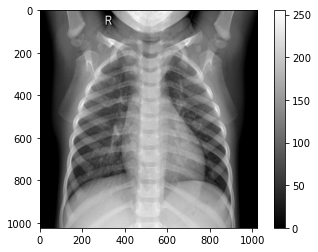

In [27]:
import cv2
image_name = 'NORMAL/NORMAL (493).png'
img = cv2.imread(image_name,0)
print('Image shape is:', img.shape)
print('exposure:', np.mean(img))

plt.imshow(img,cmap='gray')
plt.colorbar();

Image shape is: (256, 256)
exposure: 0.4392332228459549


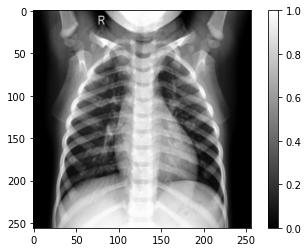

In [44]:
X = img/255
X = exposure.equalize_hist(X)
im_shape = (256, 256)
X = transform.resize(X, im_shape)
X = exposure.rescale_intensity(np.squeeze(X), out_range=(0,1))


print('Image shape is:', X.shape)
print('exposure:', np.mean(X))
plt.imshow(X,cmap='gray')
plt.colorbar();

In [45]:
X_unet = X.reshape((1, 256, 256, 1))
X_unet.shape

(1, 256, 256, 1)

In [46]:
pred = UNet.predict(X_unet)

(256, 256)


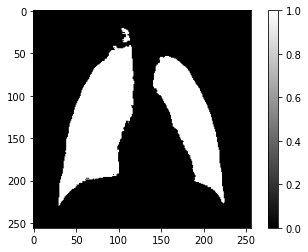

In [52]:
mask = pred[0]>0.5
mask = mask.reshape((256,256))
print(mask.shape)
plt.imshow(mask,cmap='gray')
plt.colorbar();

In [54]:
def remove_small_regions(img, size):
    """Morphologically removes small (less than size) connected regions of 0s or 1s."""
    img = morphology.remove_small_objects(img, size)
    img = morphology.remove_small_holes(img, size)
    return img

mask = remove_small_regions(mask, 0.02 * np.prod(im_shape))

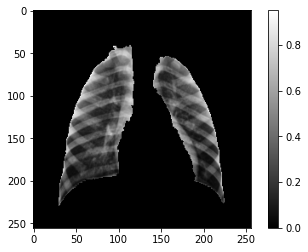

In [55]:
plt.imshow(X*mask,cmap='gray')
plt.colorbar();

In [57]:
import time
start = time.time()
#####################################################################################

for i, path in df.path.items():
    img = cv2.imread(path,0)
    X = img/255
    X = exposure.equalize_hist(X)
    im_shape = (256, 256)
    X = transform.resize(X, im_shape)
    X = exposure.rescale_intensity(np.squeeze(X), out_range=(0,1))
    X_unet = X.reshape((1, 256, 256, 1))
    pred = UNet.predict(X_unet)
    mask = pred[0]>0.5
    mask = mask.reshape((256,256))
    mask = remove_small_regions(mask, 0.02 * np.prod(im_shape))
    io.imsave('/home/baptiste/github/covid-project/Segmented/' +  path, (X*mask*255).astype(np.uint8))

#####################################################################################
end = time.time()
print(end - start)

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
<ipython-input-57-6242ba49d606>:17: UserWarning: /home/baptiste/github/covid-project/Segmented/COVID/COVID (74).png is a low contrast image
  io.imsave('/home/baptiste/github/covid-project/Segmented/' +  path, X*mask)
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
<ipython-input-57-6242ba49d606>:17: UserWarning: /home/baptiste/github/covid-project/Segmented/COVID/COVID (261).png is a low contrast image
  io.imsave('/home/baptiste/github/covid-project/Segmented/' +  path, X*mask)
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to s

<ipython-input-57-6242ba49d606>:17: UserWarning: /home/baptiste/github/covid-project/Segmented/COVID/COVID (783).png is a low contrast image
  io.imsave('/home/baptiste/github/covid-project/Segmented/' +  path, X*mask)
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
<ipython-input-57-6242ba49d606>:17: UserWarning: /home/baptiste/github/covid-project/Segmented/COVID/COVID (91).png is a low contrast image
  io.imsave('/home/baptiste/github/covid-project/Segmented/' +  path, X*mask)
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to s

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
<ipython-input-57-6242ba49d606>:17: UserWarning: /home/baptiste/github/covid-project/Segmented/COVID/COVID (1181).png is a low contrast image
  io.imsave('/home/baptiste/github/covid-project/Segmented/' +  path, X*mask)
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert imag

<ipython-input-57-6242ba49d606>:17: UserWarning: /home/baptiste/github/covid-project/Segmented/COVID/COVID (180).png is a low contrast image
  io.imsave('/home/baptiste/github/covid-project/Segmented/' +  path, X*mask)
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
<ipython-input-57-6242ba49d606>:17: UserWarning: /home/baptiste/github/covid-project/Segmented/COVID/COVID (29).png is a low contrast image
  io.imsave('/home/baptiste/github/covid-project/Segmented/' +  path, X*mask)
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to s

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
<ipython-input-57-6242ba49d606>:17: UserWarning: /home/baptiste/github/covid-project/Segmented/COVID/COVID (1007).png is a low contrast image
  io.imsave('/home/baptis

<ipython-input-57-6242ba49d606>:17: UserWarning: /home/baptiste/github/covid-project/Segmented/COVID/COVID (782).png is a low contrast image
  io.imsave('/home/baptiste/github/covid-project/Segmented/' +  path, X*mask)
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
<ipython-input-57-6242ba49d606>:17: UserWarning: /home/baptiste/github/covid-project/Segmented/COVID/COVID (32).png is a low contrast image
  io.imsave('/home/baptiste/github/covid-project/Segmented/' +  path, X*mask)
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to s

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0

<ipython-input-57-6242ba49d606>:17: UserWarning: /home/baptiste/github/covid-project/Segmented/COVID/COVID (1162).png is a low contrast image
  io.imsave('/home/baptiste/github/covid-project/Segmented/' +  path, X*mask)
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
<ipython-input-57-6242ba49d606>:17: UserWarning: /home/baptiste/github/covid-project/Segmented/COVID/COVID (662).png is a low contrast image
  io.imsave('/home/baptiste/github/covid-project/Segmented/' +  path, X*mask)
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
<ipython-input-57-6242ba49d606>:17: UserWarning: /home/baptiste/github/covid-project/

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
<ipython-input-57-6242ba49d606>:17: UserWarning: /home/baptiste/github/covid-project/Segmented/COVID/COVID (235).png is a low contrast image
  io.imsave('/home/baptiste/github/covid-project/Segmented/' +  path, X*mask)
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
<ipython-input-57-6242ba49d606>:17: UserWarning: /home/baptiste/github/covid-project/Segmented/COVID/COVID (1154).png is a low contrast image
  io.imsave('/home/baptiste/github/covid-project/Segmented/' +  path, X*mask)
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
<ipython-input-57-6242ba49d606>:17: UserWarning: /home/baptiste/github/covid-project/Segmented/COVID/COVID (859).png is a low contrast image
  io.imsave('/home/baptiste/github/covid-project/Segmented/' +  path, X*mask)
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
<ipython-input-57-6242ba49d606>:17: UserWarning: /home/baptiste/git

<ipython-input-57-6242ba49d606>:17: UserWarning: /home/baptiste/github/covid-project/Segmented/COVID/COVID (135).png is a low contrast image
  io.imsave('/home/baptiste/github/covid-project/Segmented/' +  path, X*mask)
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
<ipython-input-57-6242ba49d606>:17: UserWarning: /home/baptiste/github/covid-project/Segmented/COVID/COVID (547).png is a low contrast image
  io.imsave('/home/baptiste/github/covid-project/Segmented/' +  path, X*mask)
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to 

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
<ipython-input-57-6242ba49d606>:17: UserWarning: /home/baptiste/github/covid-project/Segmented/COVID/COVID (364).png is a low contrast image
  io.imsave('/home/baptiste/github/covid-project/Segmented/' +  path, X*mask)
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
<ipython-input-57-6242ba49d606>:17: UserWarning: /home/baptiste/github/covid-project/Segmented/COVID/COVID (680).png is a low contrast image
  io.imsave('/home/baptiste/github/covid-project/Segmented/' +  path, X*mask)
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
<ipython-input-57-6242ba49d606>:17: UserWarning: /home/baptiste/github/covid-project/Segmented/COVID/COVID (800).png is a low contrast image
  io.imsave('/home/baptiste/github/covid-project/Segmented/' +  

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
<ipython-input-57-6242ba49d606>:17: UserWarning: /home/baptiste/github/covid-project/Segmented/COVID/COVID (97).png is a low contrast image
  io.imsave('/home/baptiste/github/covid-project/Segmented/' +  path, X*mask)
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
<ipython-input-57-6242ba49d606>:17: UserWarning: /home/baptiste/github/covid-project/Segmented/COVID/COVID (697).png is a low contrast image
  io.imsave('/home/baptiste/github/covid-project/Segmented/' +  path, X*mask)
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to s

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
<ipython-input-57-6242ba49d606>:17: UserWarning: /home/baptiste/github/covid-project/Segmented/COVID/COVID (1060).png is a low contrast image
  io.imsave('/home/baptiste/github/covid-project/Segmented/' +  path, X*mask)
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
<ipython-input-57-6242ba49d606>:17: UserWarning: /home/baptiste/gi

<ipython-input-57-6242ba49d606>:17: UserWarning: /home/baptiste/github/covid-project/Segmented/COVID/COVID (763).png is a low contrast image
  io.imsave('/home/baptiste/github/covid-project/Segmented/' +  path, X*mask)
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
<ipython-input-57-6242ba49d606>:17: UserWarning: /home/baptiste/github/covid-project/Segmented/COVID/COVID (1127).png is a low contrast image
  io.imsave('/home/baptiste/github/covid-project/Segmented/' +  path, X*mask)
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
<ipython-input-57-6242ba49d606>:17: UserWarning: /home/baptiste/github/covid-project/Segmented/COVID/COVID (331).png is a low contrast image
  io.imsave('/home/baptiste/github/covid-project/Segmented/' +  path, X*mask)
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
<ipython-input-57-6242ba49d606>:17: UserWarning: /home/baptiste/github/covid-project/Segmented/COVID/COVID (227).png is a low contrast image
  io.imsave('/home/baptiste/github/covid-project/Segmented/' +  path, X*mask)
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to 

<ipython-input-57-6242ba49d606>:17: UserWarning: /home/baptiste/github/covid-project/Segmented/COVID/COVID (433).png is a low contrast image
  io.imsave('/home/baptiste/github/covid-project/Segmented/' +  path, X*mask)
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
<ipython-input-57-6242ba49d606>:17: UserWarning: /home/baptiste/github/covid-project/Segmented/COVID/COVID (319).png is a low contrast image
  io.imsave('/home/baptiste/github/covid-project/Segmented/' +  path, X*mask)
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
<ipython-input-57-6242ba49d606>:17: UserWarning: /home/baptiste/github/covid-project/S

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
<ipython-input-57-6242ba49d606>:17: UserWarning: /home/baptiste/github/covid-project/Segmented/COVID/COVID (1191).png is a low contrast image
  io.imsave('/home/baptiste/github/covid-project/Segmented/' +  path, X*mask)
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert imag

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
<ipython-input-57-6242ba49d606>:17: UserWarning: /home/baptiste/github/covid-project/Segmented/COVID/COVID (1053).png is a low contrast image
  io.imsave('/home/baptiste/github/covid-project/Segmented/' +  path, X*mask)
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
<ipython-input-57-6242ba49d606>:17: UserWarning: /home/baptiste/gi

<ipython-input-57-6242ba49d606>:17: UserWarning: /home/baptiste/github/covid-project/Segmented/COVID/COVID (735).png is a low contrast image
  io.imsave('/home/baptiste/github/covid-project/Segmented/' +  path, X*mask)
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
<ipython-input-57-6242ba49d606>:17: UserWarning: /home/baptiste/github/covid-project/Segmented/COVID/COVID (304).png is a low contrast image
  io.imsave('/home/baptiste/github/covid-project/Segmented/' +  path, X*mask)
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
<ipython-input-57-6242ba49d606>:17: UserWarning: /home/baptiste/github/covid-project/Segmented/COVID/COVID (1090).png is a low contrast image
  io.imsave('/home/baptiste/github/covid-project/Segmented/' + 

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
<ipython-input-57-6242ba49d606>:17: UserWarning: /home/baptiste/github/covid-project/Segmented/COVID/COVID (305).png is a low contrast image
  io.imsave('/home/baptiste/github/covid-project/Segmented/' +  path, X*mask)
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
<ipython-input-57-6242ba49d606>:17: UserWarning: /home/baptiste/github/covid-project/Segmented/COVID/COVID (728).png is a low contrast image
  io.imsave('/home/baptiste/github/covid-project/Segmented/' +  path, X*mask)
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
<ipython-input-57-6242ba49d606>:17: UserWarning: /home/baptiste/github/covid-project/S

<ipython-input-57-6242ba49d606>:17: UserWarning: /home/baptiste/github/covid-project/Segmented/COVID/COVID (519).png is a low contrast image
  io.imsave('/home/baptiste/github/covid-project/Segmented/' +  path, X*mask)
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
<ipython-input-57-6242ba49d606>:17: UserWarning: /home/baptiste/github/covid-project/Segmented/COVID/COVID (1160).png is a low contrast image
  io.imsave('/home/baptiste/github/covid-project/Segmented/' +  path, X*mask)
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
<ipython-input-57-6242ba49d606>:17: UserWarning: /home/baptiste/github/covid-project/Segmented/COVID/COVID (421).png is a low contrast image
  io.imsave('/home/baptiste/github/covid-project/Segmented/' + 

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
<ipython-input-57-6242ba49d606>:17: UserWarning: /home/baptiste/github/covid-project/Segmented/COVID/COVID (476).png is a low contrast image
  io.imsave('/home/baptiste/github/covid-project/Segmented/' +  path, X*mask)
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
<ipython-input-57-6242ba49d606>:17: UserWarning: /home/baptiste/github/covid-project/Segmented/COVID/COVID (393).png is a low contrast image
  io.imsave('/home/baptiste/github/covid-project/Segmented/' +  path, X*mask)
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
<ipython-input-57-6242ba49d606>:17: UserWarning: /home/baptiste/github/covid-project/Segmented/COVID/COVID (736).png is a low contrast image
  io.imsave('/home/baptiste/github/covid-project/Segmented/' +  

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
<ipython-input-57-6242ba49d606>:17: UserWarning: /home/baptiste/github/covid-project/Segmented/COVID/COVID (545).png is a low contrast image
  io.imsave('/home/baptiste/github/covid-project/Segmented/' +  path, X*mask)
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
<ipython-input-57-6242ba49d606>:17: UserWarning: /home/baptiste/github/covid-project/Segmented/COVID/COVID (194).png is a low contrast image
  io.imsave('/home/baptiste/github/covid-proj

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
<ipython-input-57-6242ba49d606>:17: UserWarning: /home/baptiste/github/covid-project/Segmented/COVID/COVID (207).png is a low contrast image
  io.imsave('/home/baptiste/github/covid-project/Segmented/' +  path, X*mask)
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
<ipython-input-57-6242ba49d606>:17: UserWarning: /home/baptiste/github/covid-project/Segmented/COVID/COVID (1169).png is a low contrast image
  io.imsave('/home/baptiste/github/covid-project/Segmented/' +  path, X*mask)
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
<ipython-input-57-6242ba49d606>:17: UserWarning: /home/baptiste/github/covid-project/Segmented/COVID/COVID (704).png is a low contrast image
  io.imsave('/home/baptiste/github/covid-project/Segmented/' +  path, X*mask)
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
<ipython-input-57-6242ba49d606>:17: UserWarning: /home/baptiste/github/covid-project/Segmented/COVID/COVID (512).png is a low contrast image
  io.imsave('/home/baptist

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
<ipython-input-57-6242ba49d606>:17: UserWarning: /home/baptiste/github/covid-project/Segmented/COVID/COVID (377).png is a low contrast image
  io.imsave('/home/baptiste/github/covid-project/Segmented/' +  path, X*mask)
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
<ipython-input-57-6242ba49d606>:17: UserWarning: /home/baptiste/git

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
<ipython-input-57-6242ba49d606>:17: UserWarning: /home/baptiste/github/covid-project/Segmented/Viral Pneumonia/Viral Pneumonia (916).png is a low contrast image
  io.imsave('/home/baptiste/github/covid-project/Segmented/' +  path, X*mask)
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
<ipython-input-57-6242ba49d606>:17: UserWarning: /home/baptiste/github/covid-project/Segmented/Viral Pneumonia/Viral Pneumonia (1160).png is a low contrast image
  io.

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
<ipython-input-57-6242ba49d606>:17: UserWarning: /home/baptiste/github/covid-project/Segmented/Viral Pneumonia/Viral Pneumonia (658).png is a low contrast image
  io.imsave('/home/baptiste/github/covid-project/Segmented/' +  path, X*mask)
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
<ipython-input-57-6242ba49d606>:17: UserWarning

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
<ipython-input-57-6242ba49d606>:17: UserWarning:

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
<ipython-input-57-6242ba49d606>:17: UserWarning: /home/baptiste/github/covid-project/Segmented/Viral Pneumonia/Viral Pneumonia (181).png is a low contrast image
  io.imsave('/home/baptiste/github/covid-project/Segmented/' +  path, X*mask)
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [

<ipython-input-57-6242ba49d606>:17: UserWarning: /home/baptiste/github/covid-project/Segmented/Viral Pneumonia/Viral Pneumonia (931).png is a low contrast image
  io.imsave('/home/baptiste/github/covid-project/Segmented/' +  path, X*mask)
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
<ipython-input-57-6242ba49d606>:17: UserWarning: /home/baptiste/github/covid-project/Segmented/Viral Pneumonia/Viral Pneumonia (175).png is a low contrast image
  io.

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0

<ipython-input-57-6242ba49d606>:17: UserWarning: /home/baptiste/github/covid-project/Segmented/Viral Pneumonia/Viral Pneumonia (639).png is a low contrast image
  io.imsave('/home/baptiste/github/covid-project/Segmented/' +  path, X*mask)
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
<ipython-input-57-6242ba49d606>:17: UserWarning

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
<ipython-input-57-6242ba49d606>:17: UserWarning: /home/baptiste/github/covid-project/Segmented/Viral Pneumonia/Viral Pneumonia (170).png is a low contrast image
  io.imsave('/home/baptiste/github/covid-project/Segmented/' +  path, X*mask)
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
<ipython-input-57-6242ba49d606>:17: UserWarning: /home/baptiste/github/covid-project/Segmented/Viral Pneumonia/Viral Pneumonia (352).png is a low contrast image
  io.imsave('/home/baptiste/github/covid-project/Segmented/' +  path, X*mask)
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
<ipython-input-57-6242ba49d606>:17: UserWarning: /home/baptiste/github/covid-project/Segmented/Viral Pneumonia/Viral Pneumonia (87).png is a low contrast image
  io.imsave('/home/baptiste/github/covid-project/Segmented/' +  path, X*mask)
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
<ipython-input-57-6242ba49d606>:17: UserWarning: /home/baptiste/github/covid-project/Segmented/Viral Pneumonia/Viral Pneumonia (254).png is a low contrast image
  io.imsave('/home/baptiste/github/covid-project/Segmented/' +  path, X*mask)
Lossy conversion from float64 to uint8. Range [

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
<ipython-input-57-6242ba49d606>:17: UserWarning: /home/baptiste/github/covid-project/Segmented/Viral Pneumonia/Viral Pneumonia (1215).png is a low contrast image
  io.imsave('/home/baptiste/github/covid-project/Segmented/' +  path, X*mask)
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range 

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
<ipython-input-57-6242ba49d606>:17: UserWarning: /home/baptiste/github/covid-project/Segmented/Viral Pneumonia/Viral Pneumonia (378).png is a low contrast image
  io.i

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
<ipython-input-57-6242ba49d606>:17: UserWarning: /home/baptiste/github/covid-project/Segmented/Viral Pneumonia/Viral Pneumonia (1251).png is a low contrast image
  io.imsave('/home/baptiste/github/covid-project/Segmented/' +  path, X*mask)
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range 

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
<ipython-input-57-6242ba49d606>:17: UserWarning: /home/baptiste/github/covid-project/Segmented/Viral Pneumonia/Viral Pneumonia (201).png is a low contrast image
  io.imsave('/home/baptiste/github/covid-project/Segmented/' +  path, X*mask)
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
<ipython-input-57-6242ba49d606>:17: UserWarning: /home/baptiste/github/covid-project/Segmented/Viral Pneumonia/Viral Pneumonia (1061).png is a low contrast image
  io.

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
<ipython-input-57-6242ba49d606>:17: UserWarning: /home/baptiste/github/covid-project/Segmented/Viral Pneumonia/Viral Pneumonia (594).png is a low contrast image
  io.imsave('/home/baptiste/github/covid-project/Segmented/' +  path, X*mask)
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
<ipython-input-57-6242ba49d606>:17: UserWarning: /home/baptiste/github/covid-project/Segmented/Viral Pneumonia/Viral Pneumonia (638).png is a low contrast image
  io.imsave('/home/baptiste/github/covid-project/Segmented/' +  path, X*mask)
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
<ipython-input-57-6242ba49d606>:17: UserWarning: /home/baptiste/github/covid-project/Segmented/Viral Pneumonia/Viral Pneumonia (33).png is a low contrast image
  io.i

840.5424845218658


Image shape is: (256, 256)
exposure: 145.89463806152344


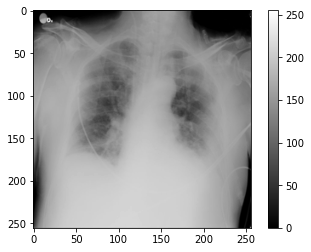

In [67]:
image_name = 'COVID/COVID (1).png'
img = cv2.imread(image_name,0)
print('Image shape is:', img.shape)
print('exposure:', np.mean(img))

plt.imshow(img,cmap='gray')
plt.colorbar();

Image shape is: (256, 256)
exposure: 155.7593994140625


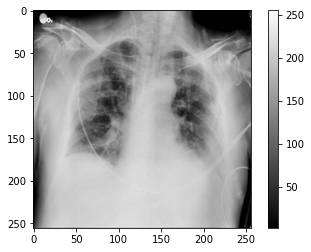

In [73]:
clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
X = clahe.apply(img)
print('Image shape is:', X.shape)
print('exposure:', np.mean(X))
plt.imshow(X,cmap='gray')
plt.colorbar();

Image shape is: (256, 256)
exposure: 0.49551491721051655


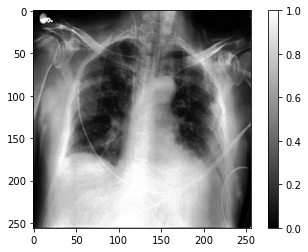

In [74]:
X = X/255
X = exposure.equalize_hist(X)
im_shape = (256, 256)
X = transform.resize(X, im_shape)
X = exposure.rescale_intensity(np.squeeze(X), out_range=(0,1))


print('Image shape is:', X.shape)
print('exposure:', np.mean(X))
plt.imshow(X,cmap='gray')
plt.colorbar();

In [75]:
X_unet = X.reshape((1, 256, 256, 1))
X_unet.shape

(1, 256, 256, 1)

In [76]:
pred = UNet.predict(X_unet)

(256, 256)


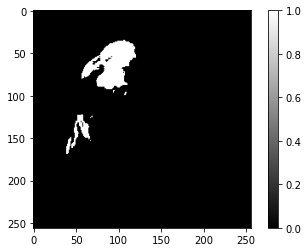

In [77]:
mask = pred[0]>0.5
mask = mask.reshape((256,256))
print(mask.shape)
plt.imshow(mask,cmap='gray')
plt.colorbar();

Essai avec un autre modèle unet pré-entrainé

In [2]:
from tensorflow.keras.layers import Conv2D, Conv2DTranspose, MaxPooling2D, Input, concatenate
from tensorflow.keras import Model
from tensorflow.keras.models import load_model

import tensorflow as tf, cv2, numpy as np

%matplotlib inline
import matplotlib.pyplot as plt, matplotlib.cm as cm

from skimage.filters import rank
from skimage.morphology import disk

In [3]:
def unet(input_size=(256,256,1)):
    inputs = Input(input_size)
    
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool1)
    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool2)
    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(pool3)
    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(pool4)
    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(conv5)

    up6 = concatenate([Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(conv5), conv4], axis=3)
    conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(up6)
    conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv6)

    up7 = concatenate([Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(conv6), conv3], axis=3)
    conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(up7)
    conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv7)

    up8 = concatenate([Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conv7), conv2], axis=3)
    conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(up8)
    conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv8)

    up9 = concatenate([Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(conv8), conv1], axis=3)
    conv9 = Conv2D(32, (3, 3), activation='relu', padding='same')(up9)
    conv9 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv9)

    conv10 = Conv2D(1, (1, 1), activation='sigmoid')(conv9)

    return Model(inputs=[inputs], outputs=[conv10])

segmentor = unet(input_size=(320, 320, 1))
segmentor.load_weights('cxr_reg_weights.hdf5')

Image shape is: (320, 320)
exposure: 0.4955649291373229


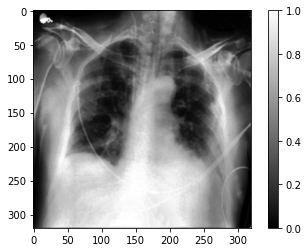

In [81]:
clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
X = clahe.apply(img)
X = X/255
X = exposure.equalize_hist(X)
im_shape = (320, 320)
X = transform.resize(X, im_shape)
X = exposure.rescale_intensity(np.squeeze(X), out_range=(0,1))


print('Image shape is:', X.shape)
print('exposure:', np.mean(X))
plt.imshow(X,cmap='gray')
plt.colorbar();

In [82]:
X_unet = X.reshape((1, 320, 320, 1))
X_unet.shape

(1, 320, 320, 1)

In [83]:
pred = segmentor.predict(X_unet)

(320, 320)


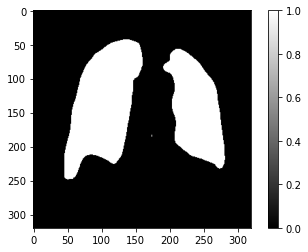

In [100]:
mask = pred[0]>0.5
mask = mask.reshape((320,320))
print(mask.shape)
plt.imshow(mask,cmap='gray')
plt.colorbar();

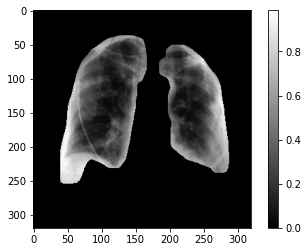

In [101]:
mask = remove_small_regions(mask, 0.02 * np.prod((320,320)))
kernel = np.ones((5, 5))
mask = cv2.dilate(np.float32(mask), kernel=kernel, iterations=3)
plt.imshow(X*mask,cmap='gray')
plt.colorbar();

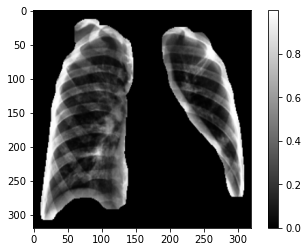

In [104]:
mask_y, mask_x = np.where(mask==1)
MARGIN = 10
start_x = np.min(mask_x) - MARGIN
end_x = np.max(mask_x) + MARGIN
start_y = np.min(mask_y) - MARGIN
end_y = np.max(mask_y) + MARGIN
mask_cropped = mask[start_y:end_y, start_x:end_x]
mask_cropped_resized = cv2.resize(mask_cropped, dsize=(320, 320))
img_cropped = X[start_y:end_y, start_x:end_x]
img_cropped_resized = cv2.resize(img_cropped, dsize=(320, 320))

plt.imshow(img_cropped_resized*mask_cropped_resized,cmap='gray')
plt.colorbar();

In [107]:
import time
import tqdm
start = time.time()
#####################################################################################

area = {}
for i, path in tqdm(df.path.items()):
    img = cv2.imread(path,0)
    X = clahe.apply(img)
    X = X/255
    X = exposure.equalize_hist(X)
    im_shape = (320, 320)
    X = transform.resize(X, im_shape)
    X = exposure.rescale_intensity(np.squeeze(X), out_range=(0,1))
    X_unet = X.reshape((1, 320, 320, 1))
    pred = segmentor.predict(X_unet)
    mask = pred[0]>0.5
    mask = mask.reshape(im_shape)
    mask = remove_small_regions(mask, 0.02 * np.prod(im_shape))
    mask = cv2.dilate(np.float32(mask), kernel=kernel, iterations=3)
    area[path] = mask.sum()
    io.imsave('/home/baptiste/github/covid-project/segmented_new/' +  path, (X*mask*255).astype(np.uint8))

#####################################################################################
end = time.time()
print(end - start)

COVID/COVID (934).png
COVID/COVID (296).png
COVID/COVID (74).png
COVID/COVID (261).png
COVID/COVID (978).png
COVID/COVID (285).png
COVID/COVID (195).png
COVID/COVID (1092).png
COVID/COVID (869).png
COVID/COVID (1052).png
COVID/COVID (493).png
COVID/COVID (636).png
COVID/COVID (717).png
COVID/COVID (640).png
COVID/COVID (1091).png
COVID/COVID (441).png
COVID/COVID (961).png
COVID/COVID (633).png
COVID/COVID (894).png
COVID/COVID (424).png
COVID/COVID (595).png
COVID/COVID (429).png
COVID/COVID (1114).png
COVID/COVID (738).png
COVID/COVID (222).png
COVID/COVID (553).png
COVID/COVID (491).png
COVID/COVID (702).png
COVID/COVID (1037).png
COVID/COVID (485).png
COVID/COVID (573).png
COVID/COVID (593).png
COVID/COVID (805).png
COVID/COVID (245).png
COVID/COVID (828).png
COVID/COVID (813).png
COVID/COVID (783).png
COVID/COVID (566).png
COVID/COVID (839).png
COVID/COVID (307).png
COVID/COVID (91).png
COVID/COVID (960).png
COVID/COVID (718).png
COVID/COVID (1104).png
COVID/COVID (347).png
COVID/

COVID/COVID (895).png
COVID/COVID (550).png
COVID/COVID (880).png
COVID/COVID (876).png
COVID/COVID (272).png
COVID/COVID (137).png
COVID/COVID (61).png
COVID/COVID (761).png
COVID/COVID (1055).png
COVID/COVID (794).png
COVID/COVID (297).png
COVID/COVID (145).png
COVID/COVID (80).png
COVID/COVID (635).png
COVID/COVID (995).png
COVID/COVID (850).png
COVID/COVID (565).png
COVID/COVID (42).png
COVID/COVID (271).png
COVID/COVID (831).png
COVID/COVID (1175).png
COVID/COVID (500).png
COVID/COVID (859).png
COVID/COVID (643).png
COVID/COVID (902).png
COVID/COVID (217).png
COVID/COVID (183).png
COVID/COVID (383).png
COVID/COVID (114).png
COVID/COVID (690).png
COVID/COVID (948).png
COVID/COVID (1047).png
COVID/COVID (699).png
COVID/COVID (795).png
COVID/COVID (394).png
COVID/COVID (613).png
COVID/COVID (520).png
COVID/COVID (998).png
COVID/COVID (755).png
COVID/COVID (647).png
COVID/COVID (1192).png
COVID/COVID (496).png
COVID/COVID (459).png
COVID/COVID (1006).png
COVID/COVID (490).png
COVID/CO

COVID/COVID (400).png
COVID/COVID (267).png
COVID/COVID (687).png
COVID/COVID (854).png
COVID/COVID (210).png
COVID/COVID (777).png
COVID/COVID (1191).png
COVID/COVID (142).png
COVID/COVID (1043).png
COVID/COVID (405).png
COVID/COVID (599).png
COVID/COVID (946).png
COVID/COVID (660).png
COVID/COVID (679).png
COVID/COVID (156).png
COVID/COVID (467).png
COVID/COVID (376).png
COVID/COVID (310).png
COVID/COVID (122).png
COVID/COVID (1180).png
COVID/COVID (469).png
COVID/COVID (767).png
COVID/COVID (650).png
COVID/COVID (193).png
COVID/COVID (453).png
COVID/COVID (559).png
COVID/COVID (1158).png
COVID/COVID (1134).png
COVID/COVID (438).png
COVID/COVID (175).png
COVID/COVID (76).png
COVID/COVID (498).png
COVID/COVID (504).png
COVID/COVID (950).png
COVID/COVID (695).png
COVID/COVID (844).png
COVID/COVID (731).png
COVID/COVID (827).png
COVID/COVID (299).png
COVID/COVID (962).png
COVID/COVID (257).png
COVID/COVID (968).png
COVID/COVID (942).png
COVID/COVID (326).png
COVID/COVID (981).png
COVID/

COVID/COVID (997).png
COVID/COVID (933).png
COVID/COVID (1153).png
COVID/COVID (865).png
COVID/COVID (594).png
COVID/COVID (1147).png
COVID/COVID (357).png
COVID/COVID (432).png
COVID/COVID (60).png
COVID/COVID (855).png
COVID/COVID (1038).png
COVID/COVID (212).png
COVID/COVID (399).png
COVID/COVID (477).png
COVID/COVID (512).png
COVID/COVID (539).png
COVID/COVID (832).png
COVID/COVID (219).png
COVID/COVID (340).png
COVID/COVID (955).png
COVID/COVID (873).png
COVID/COVID (241).png
COVID/COVID (265).png
COVID/COVID (1031).png
COVID/COVID (415).png
COVID/COVID (649).png
COVID/COVID (1186).png
COVID/COVID (27).png
COVID/COVID (422).png
COVID/COVID (12).png
COVID/COVID (321).png
COVID/COVID (753).png
COVID/COVID (583).png
COVID/COVID (889).png
COVID/COVID (641).png
COVID/COVID (204).png
COVID/COVID (771).png
COVID/COVID (787).png
COVID/COVID (1030).png
COVID/COVID (534).png
COVID/COVID (188).png
COVID/COVID (1108).png
COVID/COVID (884).png
COVID/COVID (619).png
COVID/COVID (776).png
COVID/

NORMAL/NORMAL (1200).png
NORMAL/NORMAL (807).png
NORMAL/NORMAL (231).png
NORMAL/NORMAL (624).png
NORMAL/NORMAL (553).png
NORMAL/NORMAL (1254).png
NORMAL/NORMAL (1227).png
NORMAL/NORMAL (157).png
NORMAL/NORMAL (739).png
NORMAL/NORMAL (828).png
NORMAL/NORMAL (903).png
NORMAL/NORMAL (631).png
NORMAL/NORMAL (538).png
NORMAL/NORMAL (172).png
NORMAL/NORMAL (320).png
NORMAL/NORMAL (1187).png
NORMAL/NORMAL (127).png
NORMAL/NORMAL (792).png
NORMAL/NORMAL (977).png
NORMAL/NORMAL (1051).png
NORMAL/NORMAL (1139).png
NORMAL/NORMAL (601).png
NORMAL/NORMAL (1145).png
NORMAL/NORMAL (85).png
NORMAL/NORMAL (1212).png
NORMAL/NORMAL (556).png
NORMAL/NORMAL (1234).png
NORMAL/NORMAL (975).png
NORMAL/NORMAL (1164).png
NORMAL/NORMAL (612).png
NORMAL/NORMAL (1121).png
NORMAL/NORMAL (572).png
NORMAL/NORMAL (334).png
NORMAL/NORMAL (97).png
NORMAL/NORMAL (989).png
NORMAL/NORMAL (339).png
NORMAL/NORMAL (403).png
NORMAL/NORMAL (783).png
NORMAL/NORMAL (622).png
NORMAL/NORMAL (957).png
NORMAL/NORMAL (969).png
NORMAL/

NORMAL/NORMAL (37).png
NORMAL/NORMAL (814).png
NORMAL/NORMAL (1075).png
NORMAL/NORMAL (539).png
NORMAL/NORMAL (1109).png
NORMAL/NORMAL (928).png
NORMAL/NORMAL (1107).png
NORMAL/NORMAL (865).png
NORMAL/NORMAL (381).png
NORMAL/NORMAL (18).png
NORMAL/NORMAL (309).png
NORMAL/NORMAL (122).png
NORMAL/NORMAL (676).png
NORMAL/NORMAL (501).png
NORMAL/NORMAL (754).png
NORMAL/NORMAL (73).png
NORMAL/NORMAL (38).png
NORMAL/NORMAL (2).png
NORMAL/NORMAL (482).png
NORMAL/NORMAL (1008).png
NORMAL/NORMAL (1165).png
NORMAL/NORMAL (314).png
NORMAL/NORMAL (603).png
NORMAL/NORMAL (677).png
NORMAL/NORMAL (911).png
NORMAL/NORMAL (1098).png
NORMAL/NORMAL (589).png
NORMAL/NORMAL (904).png
NORMAL/NORMAL (1127).png
NORMAL/NORMAL (1337).png
NORMAL/NORMAL (1073).png
NORMAL/NORMAL (798).png
NORMAL/NORMAL (623).png
NORMAL/NORMAL (961).png
NORMAL/NORMAL (28).png
NORMAL/NORMAL (125).png
NORMAL/NORMAL (316).png
NORMAL/NORMAL (58).png
NORMAL/NORMAL (1260).png
NORMAL/NORMAL (1271).png
NORMAL/NORMAL (14).png
NORMAL/NORMAL 

NORMAL/NORMAL (1076).png
NORMAL/NORMAL (1315).png
NORMAL/NORMAL (511).png
NORMAL/NORMAL (251).png
NORMAL/NORMAL (1213).png
NORMAL/NORMAL (444).png
NORMAL/NORMAL (275).png
NORMAL/NORMAL (856).png
NORMAL/NORMAL (221).png
NORMAL/NORMAL (857).png
NORMAL/NORMAL (973).png
NORMAL/NORMAL (168).png
NORMAL/NORMAL (70).png
NORMAL/NORMAL (1291).png
NORMAL/NORMAL (939).png
NORMAL/NORMAL (449).png
NORMAL/NORMAL (55).png
NORMAL/NORMAL (1329).png
NORMAL/NORMAL (509).png
NORMAL/NORMAL (199).png
NORMAL/NORMAL (1195).png
NORMAL/NORMAL (653).png
NORMAL/NORMAL (346).png
NORMAL/NORMAL (1330).png
NORMAL/NORMAL (3).png
NORMAL/NORMAL (100).png
NORMAL/NORMAL (372).png
NORMAL/NORMAL (528).png
NORMAL/NORMAL (860).png
NORMAL/NORMAL (680).png
NORMAL/NORMAL (1099).png
NORMAL/NORMAL (75).png
NORMAL/NORMAL (64).png
NORMAL/NORMAL (948).png
NORMAL/NORMAL (8).png
NORMAL/NORMAL (258).png
NORMAL/NORMAL (1267).png
NORMAL/NORMAL (1071).png
NORMAL/NORMAL (364).png
NORMAL/NORMAL (477).png
NORMAL/NORMAL (392).png
NORMAL/NORMAL 

NORMAL/NORMAL (1223).png
NORMAL/NORMAL (362).png
NORMAL/NORMAL (269).png
NORMAL/NORMAL (748).png
NORMAL/NORMAL (119).png
NORMAL/NORMAL (92).png
NORMAL/NORMAL (742).png
NORMAL/NORMAL (800).png
NORMAL/NORMAL (1171).png
NORMAL/NORMAL (59).png
NORMAL/NORMAL (53).png
NORMAL/NORMAL (590).png
NORMAL/NORMAL (1174).png
NORMAL/NORMAL (1162).png
NORMAL/NORMAL (1288).png
NORMAL/NORMAL (595).png
NORMAL/NORMAL (147).png
NORMAL/NORMAL (506).png
NORMAL/NORMAL (696).png
NORMAL/NORMAL (832).png
NORMAL/NORMAL (632).png
NORMAL/NORMAL (30).png
NORMAL/NORMAL (1114).png
NORMAL/NORMAL (699).png
NORMAL/NORMAL (1046).png
NORMAL/NORMAL (94).png
NORMAL/NORMAL (1116).png
NORMAL/NORMAL (720).png
NORMAL/NORMAL (293).png
NORMAL/NORMAL (701).png
NORMAL/NORMAL (1126).png
NORMAL/NORMAL (34).png
NORMAL/NORMAL (1285).png
NORMAL/NORMAL (214).png
NORMAL/NORMAL (786).png
NORMAL/NORMAL (1235).png
NORMAL/NORMAL (261).png
NORMAL/NORMAL (898).png
NORMAL/NORMAL (628).png
NORMAL/NORMAL (452).png
NORMAL/NORMAL (500).png
NORMAL/NORM

Viral Pneumonia/Viral Pneumonia (206).png
Viral Pneumonia/Viral Pneumonia (1231).png
Viral Pneumonia/Viral Pneumonia (453).png
Viral Pneumonia/Viral Pneumonia (800).png
Viral Pneumonia/Viral Pneumonia (812).png
Viral Pneumonia/Viral Pneumonia (469).png
Viral Pneumonia/Viral Pneumonia (418).png
Viral Pneumonia/Viral Pneumonia (283).png
Viral Pneumonia/Viral Pneumonia (1097).png
Viral Pneumonia/Viral Pneumonia (117).png
Viral Pneumonia/Viral Pneumonia (586).png
Viral Pneumonia/Viral Pneumonia (296).png
Viral Pneumonia/Viral Pneumonia (788).png
Viral Pneumonia/Viral Pneumonia (786).png
Viral Pneumonia/Viral Pneumonia (465).png
Viral Pneumonia/Viral Pneumonia (795).png
Viral Pneumonia/Viral Pneumonia (419).png
Viral Pneumonia/Viral Pneumonia (235).png
Viral Pneumonia/Viral Pneumonia (790).png
Viral Pneumonia/Viral Pneumonia (81).png
Viral Pneumonia/Viral Pneumonia (1188).png
Viral Pneumonia/Viral Pneumonia (1183).png
Viral Pneumonia/Viral Pneumonia (156).png
Viral Pneumonia/Viral Pneumonia

Viral Pneumonia/Viral Pneumonia (609).png
Viral Pneumonia/Viral Pneumonia (1304).png
Viral Pneumonia/Viral Pneumonia (1273).png
Viral Pneumonia/Viral Pneumonia (714).png
Viral Pneumonia/Viral Pneumonia (721).png
Viral Pneumonia/Viral Pneumonia (305).png
Viral Pneumonia/Viral Pneumonia (1149).png
Viral Pneumonia/Viral Pneumonia (1155).png
Viral Pneumonia/Viral Pneumonia (353).png
Viral Pneumonia/Viral Pneumonia (385).png
Viral Pneumonia/Viral Pneumonia (415).png
Viral Pneumonia/Viral Pneumonia (810).png
Viral Pneumonia/Viral Pneumonia (766).png
Viral Pneumonia/Viral Pneumonia (628).png
Viral Pneumonia/Viral Pneumonia (1157).png
Viral Pneumonia/Viral Pneumonia (818).png
Viral Pneumonia/Viral Pneumonia (747).png
Viral Pneumonia/Viral Pneumonia (491).png
Viral Pneumonia/Viral Pneumonia (724).png
Viral Pneumonia/Viral Pneumonia (1316).png
Viral Pneumonia/Viral Pneumonia (488).png
Viral Pneumonia/Viral Pneumonia (181).png
Viral Pneumonia/Viral Pneumonia (213).png
Viral Pneumonia/Viral Pneumo

Viral Pneumonia/Viral Pneumonia (656).png
Viral Pneumonia/Viral Pneumonia (484).png
Viral Pneumonia/Viral Pneumonia (634).png
Viral Pneumonia/Viral Pneumonia (785).png
Viral Pneumonia/Viral Pneumonia (330).png
Viral Pneumonia/Viral Pneumonia (813).png
Viral Pneumonia/Viral Pneumonia (584).png
Viral Pneumonia/Viral Pneumonia (895).png
Viral Pneumonia/Viral Pneumonia (823).png
Viral Pneumonia/Viral Pneumonia (477).png
Viral Pneumonia/Viral Pneumonia (426).png
Viral Pneumonia/Viral Pneumonia (759).png
Viral Pneumonia/Viral Pneumonia (522).png
Viral Pneumonia/Viral Pneumonia (808).png
Viral Pneumonia/Viral Pneumonia (764).png
Viral Pneumonia/Viral Pneumonia (1117).png
Viral Pneumonia/Viral Pneumonia (780).png
Viral Pneumonia/Viral Pneumonia (1271).png
Viral Pneumonia/Viral Pneumonia (474).png
Viral Pneumonia/Viral Pneumonia (1030).png
Viral Pneumonia/Viral Pneumonia (1051).png
Viral Pneumonia/Viral Pneumonia (361).png
Viral Pneumonia/Viral Pneumonia (732).png
Viral Pneumonia/Viral Pneumoni

Viral Pneumonia/Viral Pneumonia (833).png
Viral Pneumonia/Viral Pneumonia (1068).png
Viral Pneumonia/Viral Pneumonia (167).png
Viral Pneumonia/Viral Pneumonia (515).png
Viral Pneumonia/Viral Pneumonia (82).png
Viral Pneumonia/Viral Pneumonia (1345).png
Viral Pneumonia/Viral Pneumonia (1190).png
Viral Pneumonia/Viral Pneumonia (692).png
Viral Pneumonia/Viral Pneumonia (1163).png
Viral Pneumonia/Viral Pneumonia (291).png
Viral Pneumonia/Viral Pneumonia (455).png
Viral Pneumonia/Viral Pneumonia (783).png
Viral Pneumonia/Viral Pneumonia (668).png
Viral Pneumonia/Viral Pneumonia (547).png
Viral Pneumonia/Viral Pneumonia (1236).png
Viral Pneumonia/Viral Pneumonia (892).png
Viral Pneumonia/Viral Pneumonia (1050).png
Viral Pneumonia/Viral Pneumonia (1104).png
Viral Pneumonia/Viral Pneumonia (476).png
Viral Pneumonia/Viral Pneumonia (772).png
Viral Pneumonia/Viral Pneumonia (1209).png
Viral Pneumonia/Viral Pneumonia (771).png
Viral Pneumonia/Viral Pneumonia (303).png
Viral Pneumonia/Viral Pneum

Viral Pneumonia/Viral Pneumonia (133).png
Viral Pneumonia/Viral Pneumonia (956).png
Viral Pneumonia/Viral Pneumonia (973).png
Viral Pneumonia/Viral Pneumonia (1284).png
Viral Pneumonia/Viral Pneumonia (130).png
Viral Pneumonia/Viral Pneumonia (394).png
Viral Pneumonia/Viral Pneumonia (96).png
Viral Pneumonia/Viral Pneumonia (1002).png
Viral Pneumonia/Viral Pneumonia (1283).png
Viral Pneumonia/Viral Pneumonia (847).png
Viral Pneumonia/Viral Pneumonia (228).png
Viral Pneumonia/Viral Pneumonia (918).png
Viral Pneumonia/Viral Pneumonia (806).png
Viral Pneumonia/Viral Pneumonia (1141).png
Viral Pneumonia/Viral Pneumonia (876).png
Viral Pneumonia/Viral Pneumonia (526).png
Viral Pneumonia/Viral Pneumonia (124).png
Viral Pneumonia/Viral Pneumonia (979).png
Viral Pneumonia/Viral Pneumonia (342).png
Viral Pneumonia/Viral Pneumonia (44).png
Viral Pneumonia/Viral Pneumonia (752).png
Viral Pneumonia/Viral Pneumonia (344).png
Viral Pneumonia/Viral Pneumonia (122).png
Viral Pneumonia/Viral Pneumonia 

Viral Pneumonia/Viral Pneumonia (21).png
Viral Pneumonia/Viral Pneumonia (952).png
Viral Pneumonia/Viral Pneumonia (1221).png
Viral Pneumonia/Viral Pneumonia (331).png
Viral Pneumonia/Viral Pneumonia (1280).png
Viral Pneumonia/Viral Pneumonia (242).png
Viral Pneumonia/Viral Pneumonia (1058).png
Viral Pneumonia/Viral Pneumonia (182).png
Viral Pneumonia/Viral Pneumonia (832).png
Viral Pneumonia/Viral Pneumonia (92).png
Viral Pneumonia/Viral Pneumonia (1020).png
Viral Pneumonia/Viral Pneumonia (459).png
Viral Pneumonia/Viral Pneumonia (827).png
Viral Pneumonia/Viral Pneumonia (837).png
Viral Pneumonia/Viral Pneumonia (201).png
Viral Pneumonia/Viral Pneumonia (944).png
Viral Pneumonia/Viral Pneumonia (802).png
Viral Pneumonia/Viral Pneumonia (1135).png
Viral Pneumonia/Viral Pneumonia (1080).png
Viral Pneumonia/Viral Pneumonia (923).png
Viral Pneumonia/Viral Pneumonia (773).png
Viral Pneumonia/Viral Pneumonia (143).png
Viral Pneumonia/Viral Pneumonia (110).png
Viral Pneumonia/Viral Pneumoni

Viral Pneumonia/Viral Pneumonia (1178).png
Viral Pneumonia/Viral Pneumonia (280).png
Viral Pneumonia/Viral Pneumonia (289).png
Viral Pneumonia/Viral Pneumonia (1226).png
Viral Pneumonia/Viral Pneumonia (960).png
Viral Pneumonia/Viral Pneumonia (103).png
Viral Pneumonia/Viral Pneumonia (757).png
Viral Pneumonia/Viral Pneumonia (511).png
Viral Pneumonia/Viral Pneumonia (902).png
Viral Pneumonia/Viral Pneumonia (9).png
Viral Pneumonia/Viral Pneumonia (855).png
Viral Pneumonia/Viral Pneumonia (1052).png
Viral Pneumonia/Viral Pneumonia (1303).png
Viral Pneumonia/Viral Pneumonia (760).png
650.9685878753662


In [109]:
import pickle
def save_obj(obj, name ):
    with open(name + '.pkl', 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)
def load_obj(name ):
    with open(name + '.pkl', 'rb') as f:
        return pickle.load(f)

save_obj(area, 'mask_area')

In [116]:
import seaborn as sns
df = df.set_index('path')
df['area'] = pd.Series(area)
df.head()

,Class,height,width,channel,B&W,luminosite,area
path,,,,,,,
COVID/COVID (934).png,covid,331.0,331.0,3.0,True,106.488376,37841.0
COVID/COVID (296).png,covid,256.0,256.0,3.0,True,119.666504,39366.0
COVID/COVID (74).png,covid,256.0,256.0,3.0,True,153.078995,38131.0
COVID/COVID (261).png,covid,256.0,256.0,3.0,True,186.787781,27607.0
COVID/COVID (978).png,covid,331.0,331.0,3.0,True,159.006818,14699.0


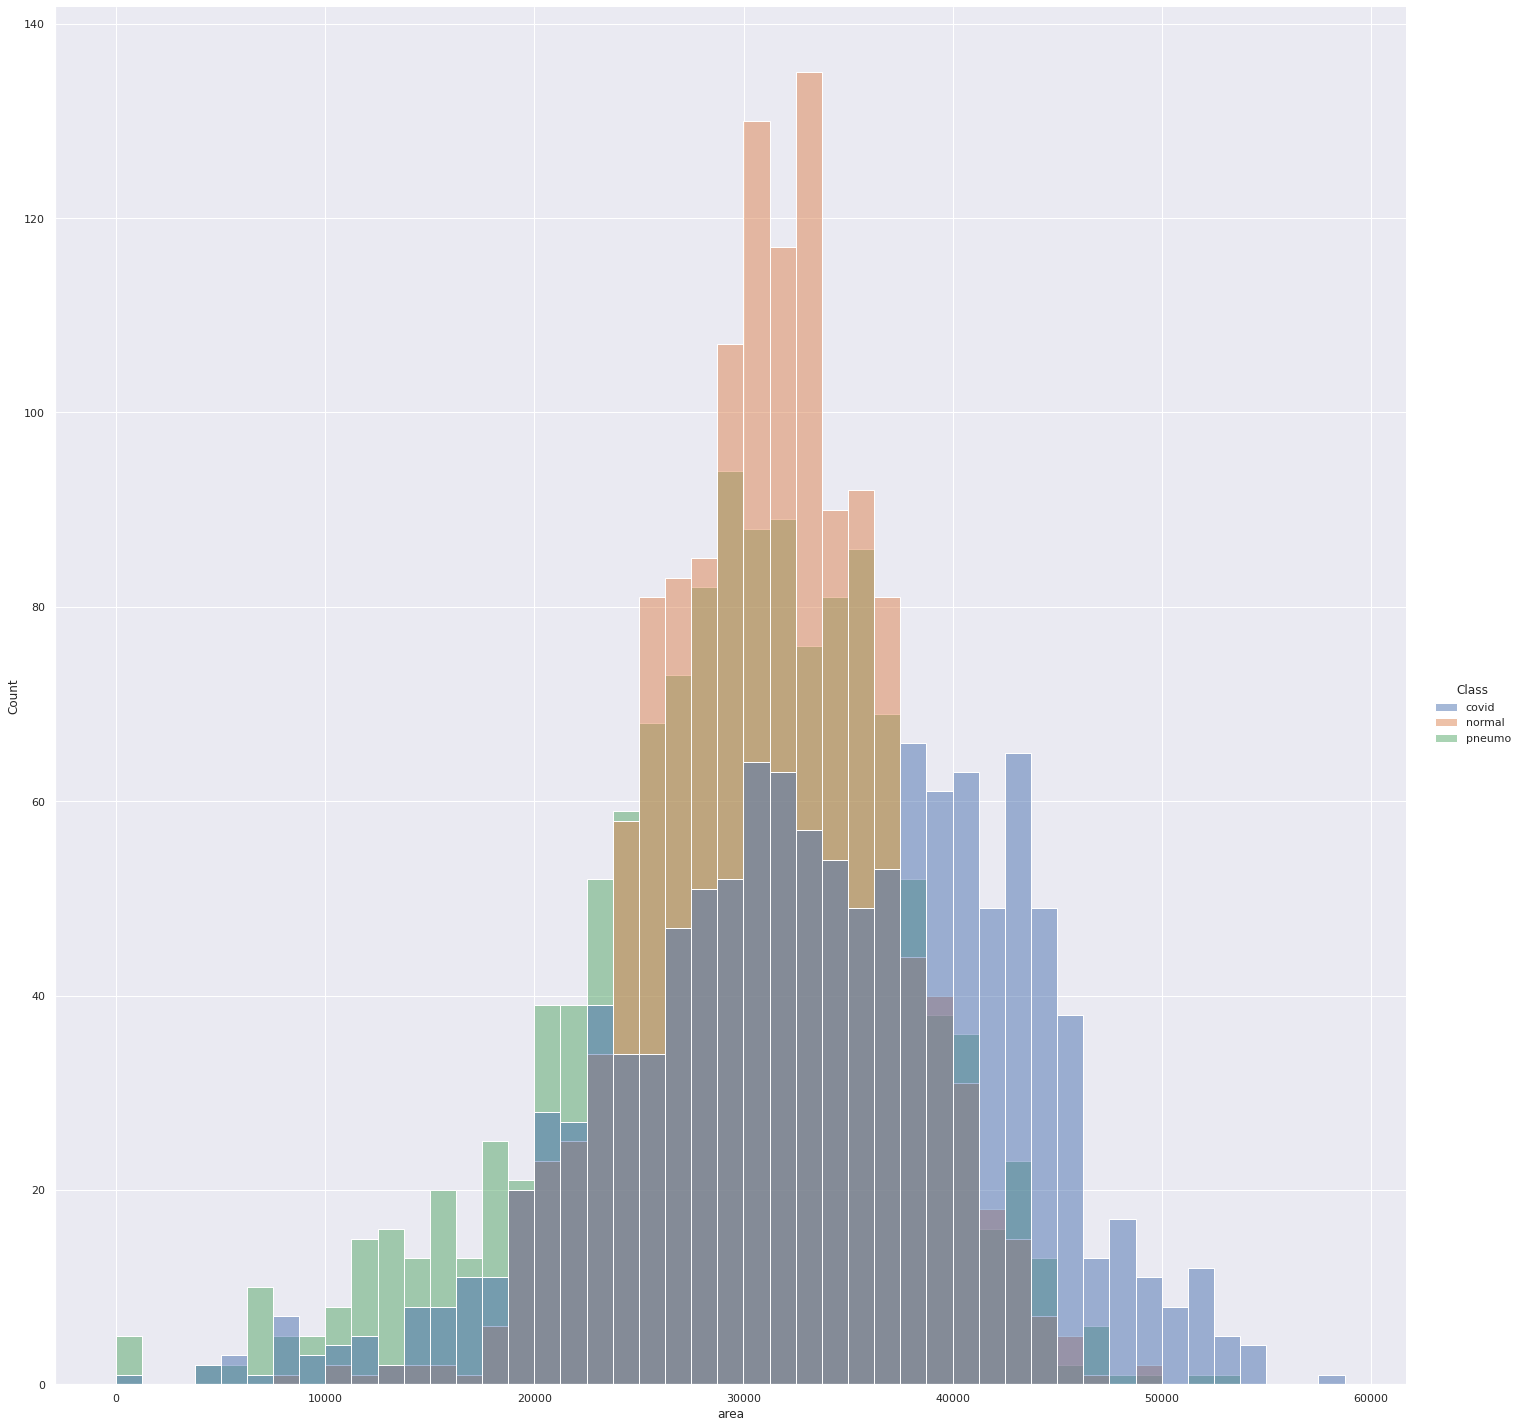

In [122]:
sns.displot(x = 'area', data = df, hue = 'Class', height = 20, multiple="stack");

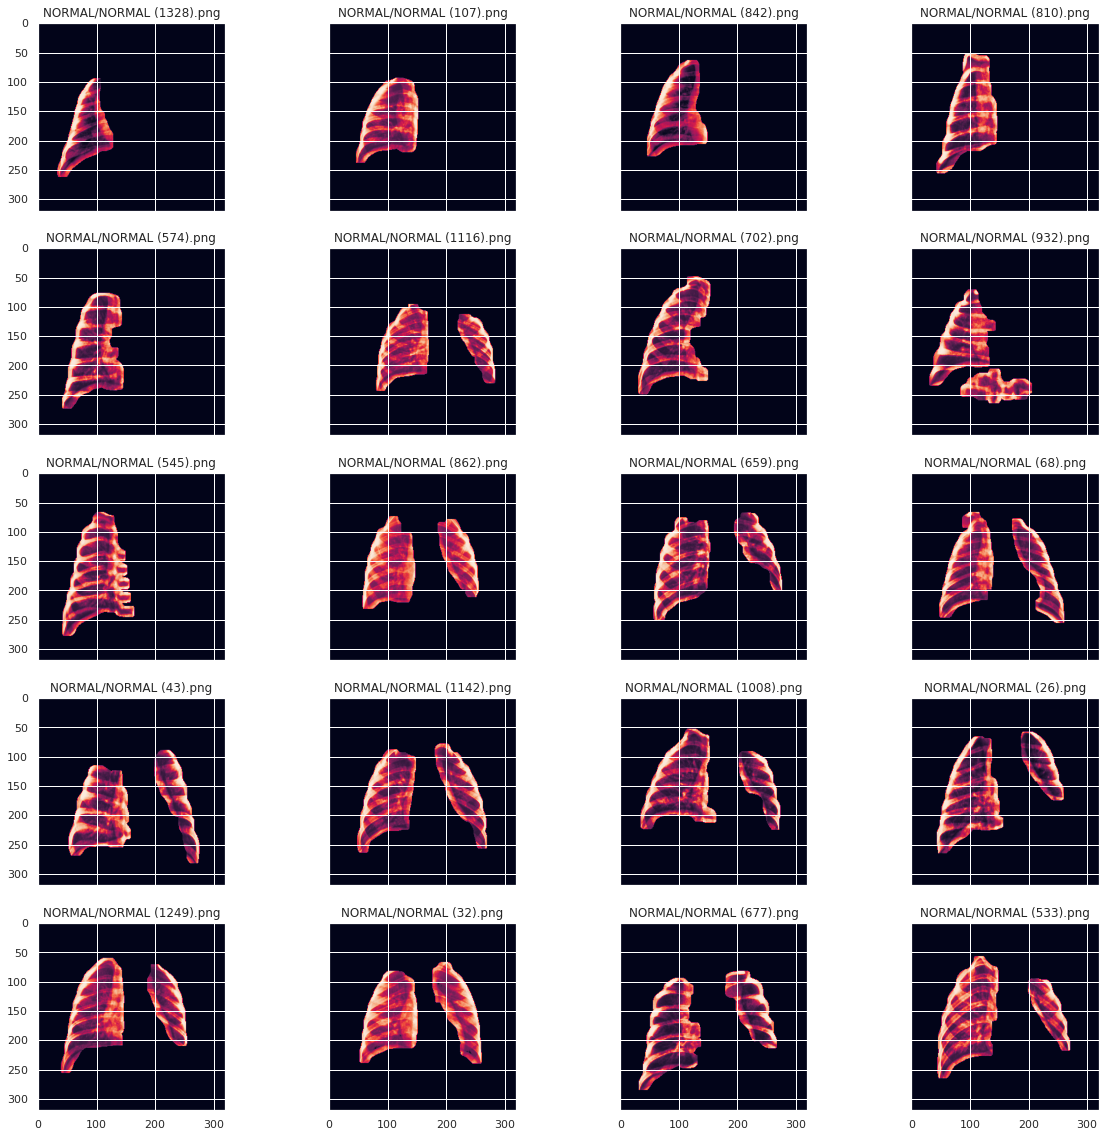

In [134]:
idx = list(df.loc[df['Class'] == 'normal', 'area'].sort_values().head(20).index)

os.chdir('/home/baptiste/github/covid-project/segmented_new')
fig, axes = plt.subplots(5, 4, figsize=(20, 20), sharex = True, sharey = True)

axes = axes.ravel()

for ii in range(20):
    image_name = idx[ii]
    scan = plt.imread(image_name)
    axes[ii].imshow(scan);   
    axes[ii].set_title(image_name)

In [136]:
df.loc['NORMAL/NORMAL (862).png']

Class          normal
height           1024
width            1024
channel             3
B&W              True
luminosite    100.475
area            16021
Name: NORMAL/NORMAL (862).png, dtype: object

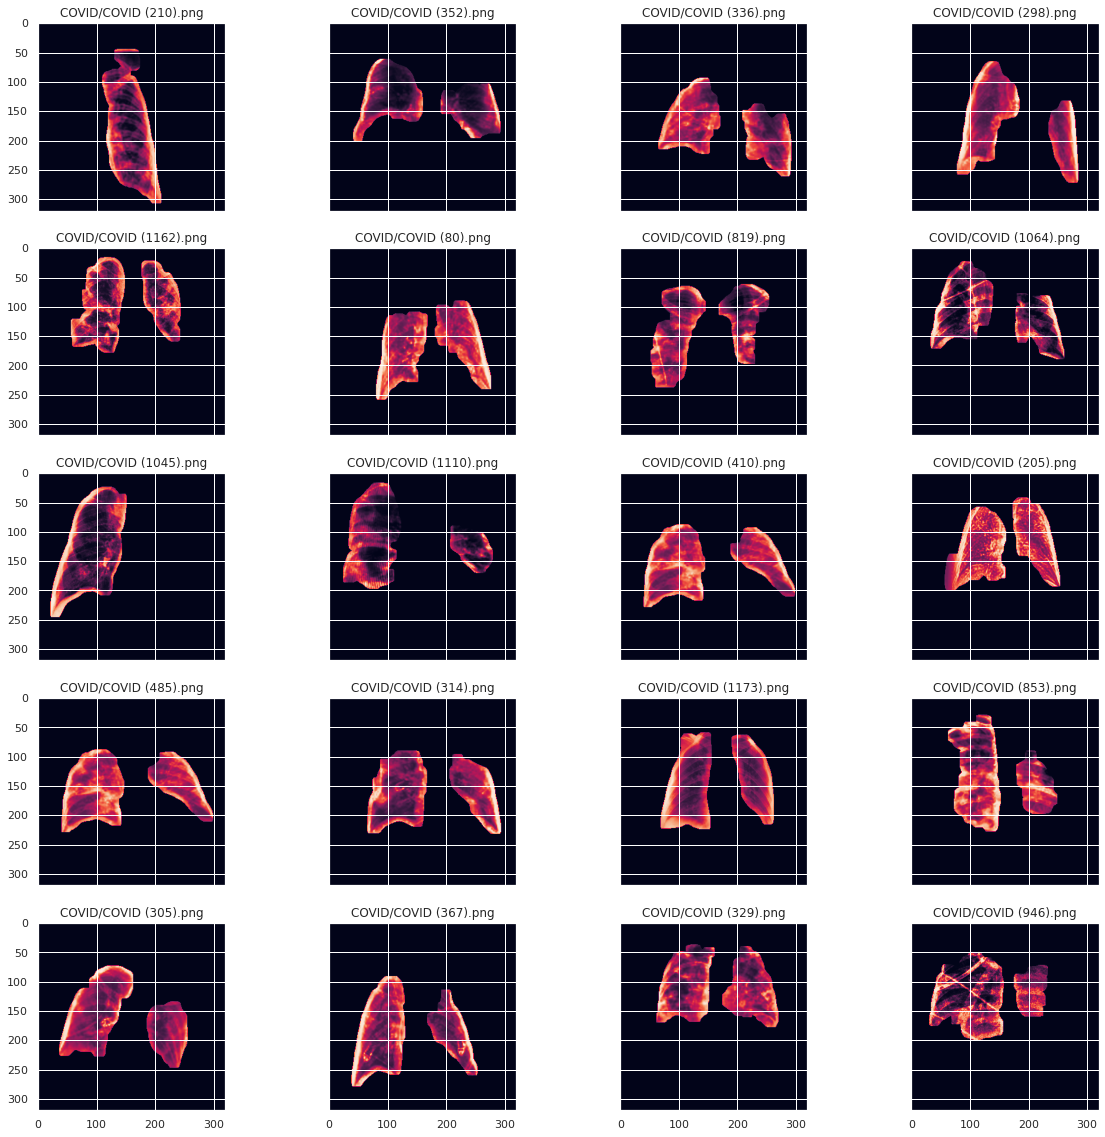

In [142]:
df.loc[(df['Class'] == 'covid') & (df['area'] < 16021)] #43 covid à supprimer

idx = list(df.loc[df['Class'] == 'covid', 'area'].sort_values().index)
idx = idx[43:43+20]

fig, axes = plt.subplots(5, 4, figsize=(20, 20), sharex = True, sharey = True)

axes = axes.ravel()

for ii in range(20):
    image_name = idx[ii]
    scan = plt.imread(image_name)
    axes[ii].imshow(scan);   
    axes[ii].set_title(image_name)